## Image alignment with "template matching" technique

In [1]:
#Load file_names_dataframe from CSV
import pandas as pd
df = pd.read_csv('file_names_dataframe.csv')
display(df.head())

,parking_lot,weather,date,file_path
0,UFPR04,Cloudy,2012-12-29,/Volumes/SSD_1/parking-lot/PKLotYoloData/NoXML...
1,UFPR04,Cloudy,2012-12-29,/Volumes/SSD_1/parking-lot/PKLotYoloData/NoXML...
2,UFPR04,Cloudy,2012-12-29,/Volumes/SSD_1/parking-lot/PKLotYoloData/NoXML...
3,UFPR04,Cloudy,2012-12-29,/Volumes/SSD_1/parking-lot/PKLotYoloData/NoXML...
4,UFPR04,Cloudy,2012-12-29,/Volumes/SSD_1/parking-lot/PKLotYoloData/NoXML...


In [ ]:
import cv2
import os
import numpy as np
# Directory to save aligned images
aligned_dir = "aligned_images/ufpr05_template_matching"
os.makedirs(aligned_dir, exist_ok=True)

# Function to align images using template matching
def align_with_template(base_image_path, target_image_path):
    # Read images
    base_image = cv2.imread(base_image_path, cv2.IMREAD_GRAYSCALE)
    target_image = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)

    # Define a template (e.g., a central region of the base image)
    h, w = base_image.shape
    template = base_image[h//4:3*h//4, w//4:3*w//4]

    # Match the template in the target image
    res = cv2.matchTemplate(target_image, template, cv2.TM_CCOEFF_NORMED)
    _, _, _, max_loc = cv2.minMaxLoc(res)

    # Compute the translation offset
    dx, dy = max_loc[0] - w//4, max_loc[1] - h//4

    # Apply translation to align the target image
    translation_matrix = np.float32([[1, 0, -dx], [0, 1, -dy]])
    aligned_image = cv2.warpAffine(cv2.imread(target_image_path), translation_matrix, (w, h))

    return aligned_image

# Filter the dataframe for UFPR05 images
ufpr05_images = df[df['parking_lot'] == 'UFPR05']
# Use the first image in UFPR05 as the base image
base_image_path = ufpr05_images.iloc[0]['file_path']

# Align all images in UFPR05
for _, row in ufpr05_images.iterrows():
    target_image_path = row['file_path']
    aligned_image = align_with_template(base_image_path, target_image_path)

    # Save the aligned image
    aligned_image_path = os.path.join(aligned_dir, os.path.basename(target_image_path))
    cv2.imwrite(aligned_image_path, aligned_image)

print(f"Aligned images saved to {aligned_dir}")

Aligned images saved to aligned_images/ufpr05


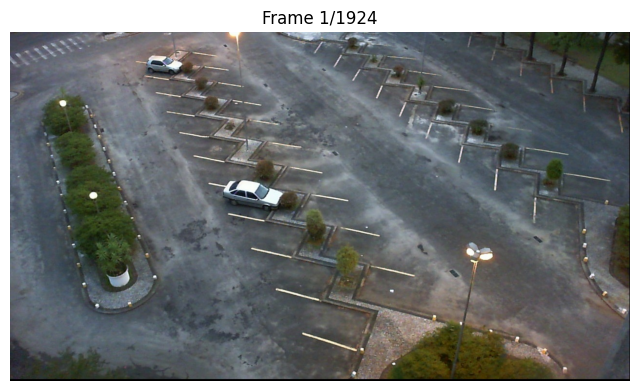

In [2]:
# Save as animation

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import os

# Path to the aligned images directory
aligned_dir = "aligned_images/ufpr05_template_matching"

# Get the list of aligned image paths
aligned_image_paths = sorted(
    [os.path.join(aligned_dir, fname) for fname in os.listdir(aligned_dir) if fname.endswith(('.jpg', '.png'))]
)

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(8, 6))

# Initialize the image display with the first aligned image
img_display = ax.imshow(Image.open(aligned_image_paths[0]))
ax.axis('off')  # Turn off axes for better visualization

# Update function for the animation
def update(frame):
    image_path = aligned_image_paths[frame]
    img = Image.open(image_path)
    img_display.set_data(img)
    ax.set_title(f"Frame {frame + 1}/{len(aligned_image_paths)}")
    return img_display,

# Create the animation
ani = FuncAnimation(
    fig, update, frames=len(aligned_image_paths), interval=500, blit=True
)

In [ ]:
# Save the animation as a GIF or MP4 (optional)
ani.save('animations/aligned_animation_template_matching.mp4', writer='ffmpeg', fps=20)  # Save as MP4